In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\fatah\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\fatah\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\fatah\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\fatah\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\fatah\anaconda3\lib\site-pack

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\fatah\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\fatah\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\fatah\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\fatah\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\fatah\anaconda3\lib\site-pack

AttributeError: _ARRAY_API not found

# Load and Prepare Data

In [2]:
df = pd.read_csv('JKSE.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.sort_index()
df.head()

,close
date,
2024-01-02,7323.587891
2024-01-03,7279.090820
2024-01-04,7359.763184
2024-01-05,7350.619141
2024-01-08,7283.575195


In [3]:
dataset = df[['close']].values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

WINDOW_SIZE = 60 
X_train, y_train = create_sequences(train_data, WINDOW_SIZE)
X_test, y_test = create_sequences(test_data, WINDOW_SIZE)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# STACKED LSTM

In [4]:
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [5]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train, 
    batch_size=32, 
    epochs=50, 
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0718 - val_loss: 0.0283
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0103 - val_loss: 0.0605
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0070 - val_loss: 0.0232
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0069 - val_loss: 0.0463
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0078 - val_loss: 0.0192
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0064 - val_loss: 0.0237
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0064 - val_loss: 0.0125
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0061 - val_loss: 0.0291
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0056 - val_loss: 0.0065
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0057 - val_loss: 0.0142
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.

# Model Evaluation

In [6]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

print('\n--- Evaluation Results ---')
print(f'Train MAE: {mean_absolute_error(y_train_inv, train_predict):.2f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(y_train_inv, train_predict)):.2f}')
print(f'Test MAE: {mean_absolute_error(y_test_inv, test_predict):.2f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test_inv, test_predict)):.2f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

--- Evaluation Results ---
Train MAE: 118.60
Train RMSE: 155.51
Test MAE: 57.50
Test RMSE: 73.22


# Visualization

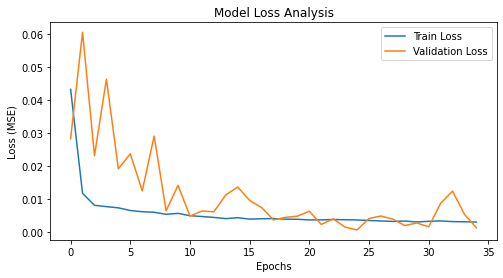

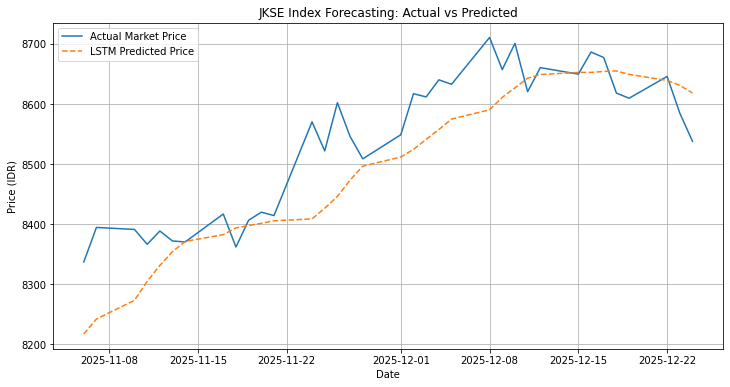

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Analysis')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size + WINDOW_SIZE:], y_test_inv, label="Actual Market Price")
plt.plot(df.index[train_size + WINDOW_SIZE:], test_predict, label="LSTM Predicted Price", linestyle='--')
plt.title('JKSE Index Forecasting: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.grid(True)
plt.show()

# Predict The Next 7 Days

In [8]:
X_FUTURE = 7
predictions = []
last_window = scaled_data[-WINDOW_SIZE:]

for i in range(X_FUTURE):
    curr_input = last_window.reshape(1, WINDOW_SIZE, 1)
    curr_pred = model.predict(curr_input)
    predictions.append(curr_pred[0])
    last_window = np.append(last_window[1:], curr_pred, axis=0)

res_future = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

future_dates = [df.index[-1] + timedelta(days=i) for i in range(1, X_FUTURE + 1)]
df_future = pd.DataFrame({'date': future_dates, 'predicted price': res_future.flatten()})
print("\n--- 7-Day Future Forecast ---")
print(df_future)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

--- 7-Day Future Forecast ---
        date  predicted price
0 2025-12-25      8599.043945
1 2025-12-26      8584.132812
2 2025-12-27      8571.275391
3 2025-12-28      8559.666992
4 2025-12-29      8548.833008
5 2025-12-30      8538.489258
6 2025-12-31      8528.471680


### 📊 Data Export for Business Intelligence (BI) Visualization

The modeling phase is concluded by exporting the consolidated results—comprising both historical backtesting predictions and the 7-day out-of-sample forecast—into a structured format (`JKSE_LSTM_Results_Tableau.csv`).

**Objectives of this Export:**
* **Interactive Exploration:** Transitioning from static plots to **Tableau Desktop** allows for dynamic time-series scaling and granular analysis of price movements.
* **Stakeholder Communication:** Bridging the gap between complex Deep Learning architectures and actionable business insights through intuitive dashboards.
* **Performance Monitoring:** Enabling real-time visual comparison between historical actuals and model-derived trajectories.

This integration demonstrates a professional end-to-end analytical pipeline, merging advanced quantitative methods with industry-standard Business Intelligence tools.

In [9]:
test_dates = df.index[train_size + WINDOW_SIZE:]
df_results = pd.DataFrame({
    'date': test_dates,
    'actual_price': y_test_inv.flatten(),
    'predicted_price': test_predict.flatten(),
    'type': 'historical'
})

df_future_export = df_future.copy() 
df_future_export.columns = ['date', 'predicted_price']
df_future_export['actual_price'] = np.nan 
df_future_export['type'] = 'future'

final_tableau_data = pd.concat([df_results, df_future_export], ignore_index=True)
final_tableau_data.to_csv('JKSE_LSTM_Results_Tableau.csv', index=False)
print(final_tableau_data.tail(10))

         date  actual_price  predicted_price        type
32 2025-12-22   8645.843750      8639.264648  historical
33 2025-12-23   8584.782227      8631.075195  historical
34 2025-12-24   8537.911133      8618.185547  historical
35 2025-12-25           NaN      8599.043945      future
36 2025-12-26           NaN      8584.132812      future
37 2025-12-27           NaN      8571.275391      future
38 2025-12-28           NaN      8559.666992      future
39 2025-12-29           NaN      8548.833008      future
40 2025-12-30           NaN      8538.489258      future
41 2025-12-31           NaN      8528.471680      future


C:\Users\fatah\AppData\Local\Temp\ipykernel_5612\3747749154.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_tableau_data = pd.concat([df_results, df_future_export], ignore_index=True)
